# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

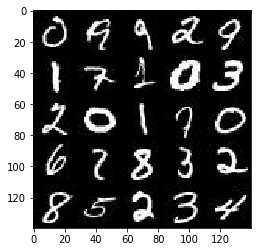

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

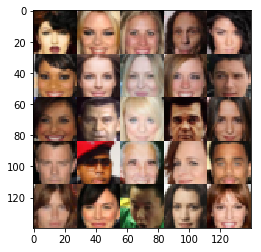

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    # tensor of real input images
    realinput = tf.placeholder(name="inputs_real", dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    
    # tensor of z data
    zdata = tf.placeholder(name="inputs_z", dtype=tf.float32, shape=(None, z_dim))
    
    # learning rate
    learningrate = tf.placeholder(name="learning_rate", dtype=tf.float32)
    
    return realinput, zdata, learningrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

### Personal Note
This is basically just a convolutional classifier.
The input to the discriminator are 28x28x3 tensors/images. 
You'll want a few convolutional layers, then a fully connected layer for the output. 
As before, we want a sigmoid output, and you'll need to return the logits as well. 
For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. 

Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with tf.layers.batch_normalization on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.1
    dropout = 0.4
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # relu1 = tf.layers.dropout(relu1,dropout)
        # print (relu1.shape)
        # 14x14x64
        
        x3 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # relu3 = tf.layers.dropout(relu3,dropout)
        # print (relu3.shape)
        # 7x7x256

        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # relu4 = tf.layers.dropout(relu4,dropout)
        # print (relu4.shape)
        # 4x4x512
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    dropout= 0.4
    # you want to reuse the variables when your not training
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # x1 = tf.layers.dropout(x1,dropout)
        # print(x1.shape)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 = tf.layers.dropout(x1,dropout)
        # print(x2.shape)
        # 14x14x256 now
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # x3 = tf.layers.dropout(x3,dropout)
        # print(x3.shape)
        # 28x28x128
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # print (logits.shape)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, image_width, image_height, image_channels = data_shape
        
    # Same code like DCGAN project cell n°13 Building the model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        #tf.reset_default_graph()
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # Same code like DCGAN project cell n°15 Train the model
                steps += 1
                
                # The batch_images are normalized to -0.5 to 0.5 
                # but the tanh layer outputs in the range of -1.0 to 1.0.
                # So the batch_images should be scaled to the appropriate range. Hence, multiply by 2.0
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images, 
                                               lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Steps: {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0020... Generator Loss: 6.2452
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 7.8710
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 8.0295
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.4237
Epoch 1/2... Discriminator Loss: 0.0003... Generator Loss: 8.4427
Epoch 1/2... Discriminator Loss: 0.0004... Generator Loss: 7.9783
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 8.6964
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.1620
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 8.9336
Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 9.2772


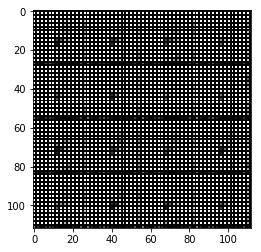

Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.5734
Epoch 1/2... Discriminator Loss: 0.0001... Generator Loss: 9.2890
Epoch 1/2... Discriminator Loss: 0.1756... Generator Loss: 64.7035
Epoch 1/2... Discriminator Loss: 15.4527... Generator Loss: 0.0018
Epoch 1/2... Discriminator Loss: 4.7800... Generator Loss: 0.4429
Epoch 1/2... Discriminator Loss: 3.0200... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 2.1968
Epoch 1/2... Discriminator Loss: 0.5314... Generator Loss: 1.7757
Epoch 1/2... Discriminator Loss: 0.7934... Generator Loss: 1.3764
Epoch 1/2... Discriminator Loss: 0.6055... Generator Loss: 6.9778


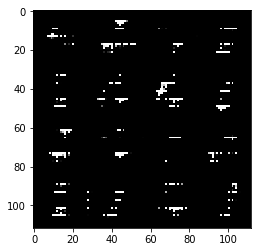

Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 2.0947
Epoch 1/2... Discriminator Loss: 5.3661... Generator Loss: 9.5482
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 2.6651
Epoch 1/2... Discriminator Loss: 0.5977... Generator Loss: 1.5082
Epoch 1/2... Discriminator Loss: 0.6326... Generator Loss: 1.3801
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 1.4899
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 3.1905
Epoch 1/2... Discriminator Loss: 2.3068... Generator Loss: 7.8782
Epoch 1/2... Discriminator Loss: 0.0943... Generator Loss: 3.2654
Epoch 1/2... Discriminator Loss: 0.4116... Generator Loss: 1.6593


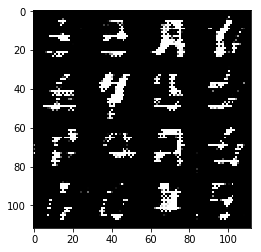

Epoch 1/2... Discriminator Loss: 0.1633... Generator Loss: 2.6051
Epoch 1/2... Discriminator Loss: 0.4696... Generator Loss: 2.7924
Epoch 1/2... Discriminator Loss: 2.0452... Generator Loss: 7.0483
Epoch 1/2... Discriminator Loss: 0.2189... Generator Loss: 2.3767
Epoch 1/2... Discriminator Loss: 0.3251... Generator Loss: 3.7597
Epoch 1/2... Discriminator Loss: 0.2533... Generator Loss: 3.6939
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 1.3746
Epoch 1/2... Discriminator Loss: 0.2917... Generator Loss: 2.3979
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 3.0310
Epoch 1/2... Discriminator Loss: 0.2796... Generator Loss: 2.6791


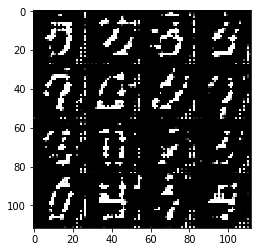

Epoch 1/2... Discriminator Loss: 4.3958... Generator Loss: 0.0277
Epoch 1/2... Discriminator Loss: 6.0837... Generator Loss: 9.2609
Epoch 1/2... Discriminator Loss: 0.1856... Generator Loss: 2.3642
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 3.2691
Epoch 1/2... Discriminator Loss: 0.5340... Generator Loss: 2.1012
Epoch 1/2... Discriminator Loss: 0.1756... Generator Loss: 2.7452
Epoch 1/2... Discriminator Loss: 0.3677... Generator Loss: 1.9093
Epoch 1/2... Discriminator Loss: 0.0640... Generator Loss: 4.8998
Epoch 1/2... Discriminator Loss: 0.2561... Generator Loss: 2.9837
Epoch 1/2... Discriminator Loss: 0.2094... Generator Loss: 2.0938


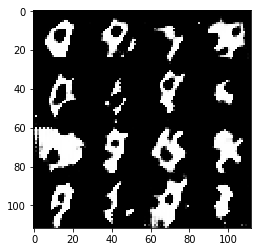

Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 0.3467... Generator Loss: 1.8460
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 0.0643... Generator Loss: 3.4144
Epoch 1/2... Discriminator Loss: 2.0297... Generator Loss: 0.2258
Epoch 1/2... Discriminator Loss: 2.4092... Generator Loss: 4.8779
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.6391
Epoch 1/2... Discriminator Loss: 0.4933... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.1770... Generator Loss: 2.0911
Epoch 1/2... Discriminator Loss: 0.0695... Generator Loss: 10.3498


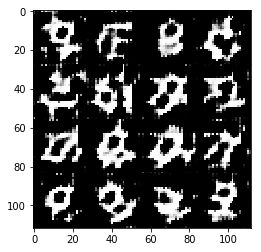

Epoch 1/2... Discriminator Loss: 3.2442... Generator Loss: 5.6048
Epoch 1/2... Discriminator Loss: 1.9022... Generator Loss: 0.5873
Epoch 1/2... Discriminator Loss: 0.5812... Generator Loss: 1.3876
Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 1.4407
Epoch 1/2... Discriminator Loss: 0.7892... Generator Loss: 4.5713
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.4534... Generator Loss: 2.0053
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 1.2156
Epoch 1/2... Discriminator Loss: 1.2725... Generator Loss: 1.0470


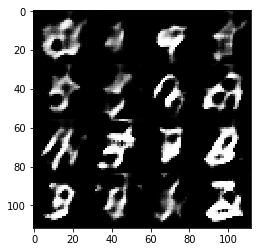

Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 1.7876
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 1.7765
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 1.6005
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.7493
Epoch 1/2... Discriminator Loss: 0.8852... Generator Loss: 0.9317
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.4422
Epoch 1/2... Discriminator Loss: 1.4021... Generator Loss: 1.0676


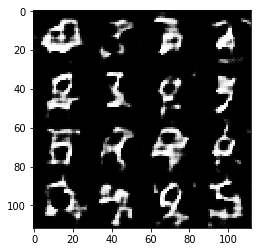

Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 1.6867
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.4288
Epoch 1/2... Discriminator Loss: 0.9068... Generator Loss: 1.2492
Epoch 1/2... Discriminator Loss: 1.5426... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.7814
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 1.7843... Generator Loss: 0.3394
Epoch 1/2... Discriminator Loss: 0.5579... Generator Loss: 1.5657
Epoch 1/2... Discriminator Loss: 2.1999... Generator Loss: 3.8398
Epoch 1/2... Discriminator Loss: 0.6909... Generator Loss: 2.7630


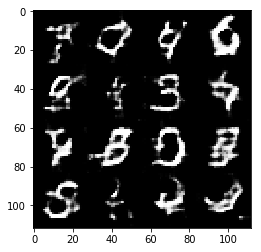

Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 1.3765
Epoch 1/2... Discriminator Loss: 1.7899... Generator Loss: 0.3377
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 1.0750
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.7299
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 1.9254
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.8319
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.0311
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 2.0594
Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 2.2450
Epoch 2/2... Discriminator Loss: 1.4583... Generator Loss: 0.4385


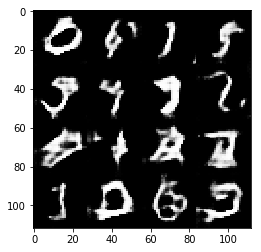

Epoch 2/2... Discriminator Loss: 2.0694... Generator Loss: 0.2451
Epoch 2/2... Discriminator Loss: 1.2240... Generator Loss: 0.5823
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.5098
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 2.3665... Generator Loss: 0.1702
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.2097
Epoch 2/2... Discriminator Loss: 2.0092... Generator Loss: 0.2303
Epoch 2/2... Discriminator Loss: 0.8864... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 5.1158... Generator Loss: 4.1915


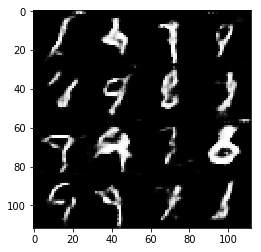

Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 1.7013
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.8010... Generator Loss: 0.3151
Epoch 2/2... Discriminator Loss: 1.4562... Generator Loss: 0.4214
Epoch 2/2... Discriminator Loss: 1.3413... Generator Loss: 0.5158
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.3936... Generator Loss: 0.4582
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 0.7318


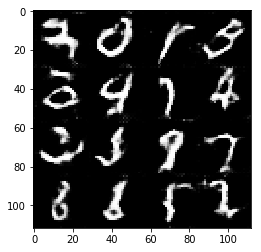

Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 0.9217
Epoch 2/2... Discriminator Loss: 1.4053... Generator Loss: 0.4939
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.4399
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 2.1744
Epoch 2/2... Discriminator Loss: 1.4619... Generator Loss: 0.4457
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 1.3237
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 1.3821


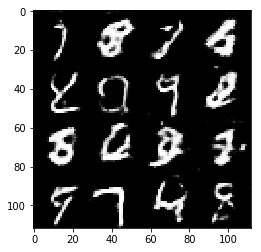

Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 0.9465
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.7926
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.6077
Epoch 2/2... Discriminator Loss: 1.4399... Generator Loss: 0.4420
Epoch 2/2... Discriminator Loss: 1.1544... Generator Loss: 0.6711
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 0.7629
Epoch 2/2... Discriminator Loss: 1.0673... Generator Loss: 1.0349
Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.4919... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 0.7804


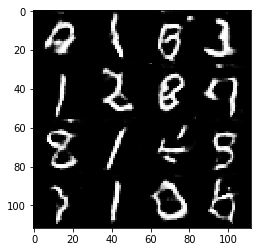

Epoch 2/2... Discriminator Loss: 1.8931... Generator Loss: 0.2739
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 2.4461
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 1.4635
Epoch 2/2... Discriminator Loss: 1.4708... Generator Loss: 2.6399
Epoch 2/2... Discriminator Loss: 2.4013... Generator Loss: 0.1539
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 1.2061... Generator Loss: 0.5960
Epoch 2/2... Discriminator Loss: 2.5408... Generator Loss: 0.1574
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 0.7258
Epoch 2/2... Discriminator Loss: 1.0139... Generator Loss: 1.2474


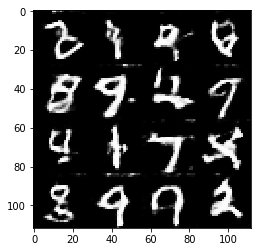

Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 1.1348... Generator Loss: 0.9663
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 0.8305
Epoch 2/2... Discriminator Loss: 3.0056... Generator Loss: 4.6185
Epoch 2/2... Discriminator Loss: 1.6338... Generator Loss: 0.3361
Epoch 2/2... Discriminator Loss: 0.9395... Generator Loss: 0.9717
Epoch 2/2... Discriminator Loss: 0.8578... Generator Loss: 1.1966
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.1171
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.5458


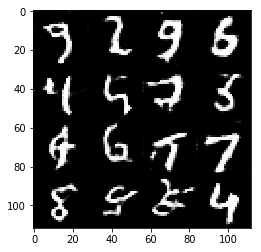

Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.5566
Epoch 2/2... Discriminator Loss: 0.7705... Generator Loss: 1.2153
Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 2.8460
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.4508
Epoch 2/2... Discriminator Loss: 0.9418... Generator Loss: 0.7915
Epoch 2/2... Discriminator Loss: 1.4717... Generator Loss: 2.9782
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.9456
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.7260


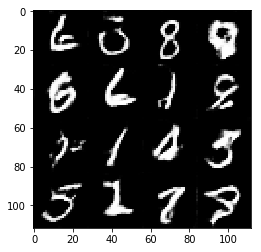

Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.5974
Epoch 2/2... Discriminator Loss: 0.4832... Generator Loss: 1.5098
Epoch 2/2... Discriminator Loss: 1.5407... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.4406
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.6500
Epoch 2/2... Discriminator Loss: 1.6868... Generator Loss: 0.3181
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 2.2290... Generator Loss: 0.1996
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.4763


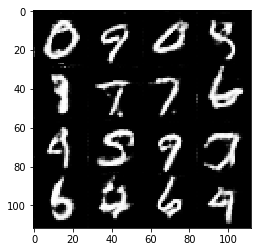

Epoch 2/2... Discriminator Loss: 1.2690... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 0.9530... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.5287... Generator Loss: 0.3790
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 2.4218
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 0.9037
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.1965


In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Training loss

Here we'll check out the training losses for the generator and discriminator.

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

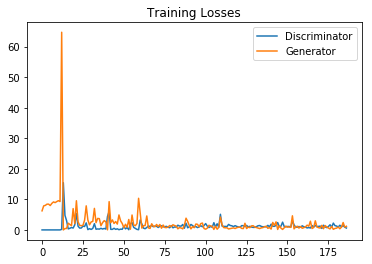

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 29.2470
Epoch 1/1... Discriminator Loss: 3.2175... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 0.0027... Generator Loss: 12.6950
Epoch 1/1... Discriminator Loss: 0.0004... Generator Loss: 18.6195
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 13.8381
Epoch 1/1... Discriminator Loss: 0.0030... Generator Loss: 6.4010
Epoch 1/1... Discriminator Loss: 0.0025... Generator Loss: 6.5301
Epoch 1/1... Discriminator Loss: 26.4801... Generator Loss: 36.1510
Epoch 1/1... Discriminator Loss: 5.6480... Generator Loss: 0.0387
Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.3910


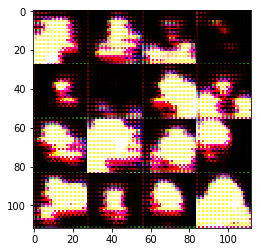

Epoch 1/1... Discriminator Loss: 0.2273... Generator Loss: 2.6245
Epoch 1/1... Discriminator Loss: 0.1147... Generator Loss: 4.1489
Epoch 1/1... Discriminator Loss: 0.0623... Generator Loss: 4.1621
Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 4.9060
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 6.2048
Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 6.6016
Epoch 1/1... Discriminator Loss: 2.6817... Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 0.5381... Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 1.8230... Generator Loss: 2.7392


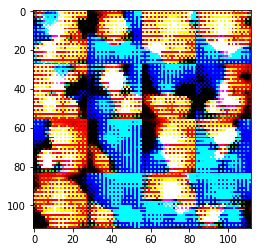

Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 1.6192
Epoch 1/1... Discriminator Loss: 0.2354... Generator Loss: 2.2128
Epoch 1/1... Discriminator Loss: 0.0793... Generator Loss: 3.6266
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 2.3850
Epoch 1/1... Discriminator Loss: 5.1060... Generator Loss: 0.0165
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.8091
Epoch 1/1... Discriminator Loss: 0.0804... Generator Loss: 3.1006
Epoch 1/1... Discriminator Loss: 0.0339... Generator Loss: 4.0851
Epoch 1/1... Discriminator Loss: 0.2242... Generator Loss: 5.5068


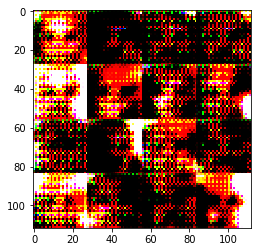

Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 2.5852
Epoch 1/1... Discriminator Loss: 0.4968... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 3.4384
Epoch 1/1... Discriminator Loss: 0.0688... Generator Loss: 3.1528
Epoch 1/1... Discriminator Loss: 0.0119... Generator Loss: 5.7192
Epoch 1/1... Discriminator Loss: 0.1205... Generator Loss: 5.8072
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 4.9425
Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 4.7629
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 4.1072
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 7.1085


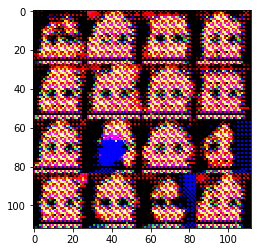

Epoch 1/1... Discriminator Loss: 0.0111... Generator Loss: 5.6914
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 4.9359
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 6.2620
Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 7.7594
Epoch 1/1... Discriminator Loss: 0.0053... Generator Loss: 5.7435
Epoch 1/1... Discriminator Loss: 0.0061... Generator Loss: 5.2981
Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 4.0444
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 5.0717
Epoch 1/1... Discriminator Loss: 0.0015... Generator Loss: 7.2627
Epoch 1/1... Discriminator Loss: 2.6209... Generator Loss: 5.1632


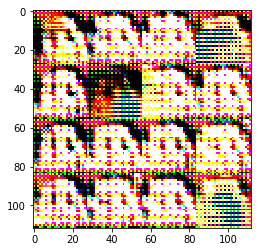

Epoch 1/1... Discriminator Loss: 0.2867... Generator Loss: 1.9784
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 4.8362
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 4.3247
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 2.1621
Epoch 1/1... Discriminator Loss: 0.0322... Generator Loss: 4.1371
Epoch 1/1... Discriminator Loss: 0.9715... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 6.4459
Epoch 1/1... Discriminator Loss: 0.6055... Generator Loss: 1.5218
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 4.8227


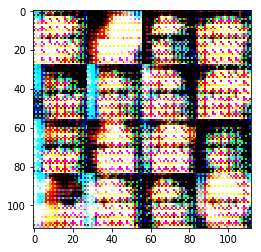

Epoch 1/1... Discriminator Loss: 0.0733... Generator Loss: 4.9876
Epoch 1/1... Discriminator Loss: 0.0492... Generator Loss: 5.0364
Epoch 1/1... Discriminator Loss: 0.0265... Generator Loss: 4.1636
Epoch 1/1... Discriminator Loss: 0.0313... Generator Loss: 4.4643
Epoch 1/1... Discriminator Loss: 0.0028... Generator Loss: 11.6031
Epoch 1/1... Discriminator Loss: 0.1406... Generator Loss: 2.9940
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 4.0362
Epoch 1/1... Discriminator Loss: 0.0250... Generator Loss: 4.2296
Epoch 1/1... Discriminator Loss: 0.0144... Generator Loss: 4.7043
Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 5.8408


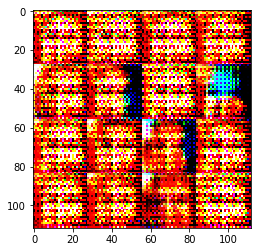

Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 5.1114
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 5.1372
Epoch 1/1... Discriminator Loss: 0.0009... Generator Loss: 7.9540
Epoch 1/1... Discriminator Loss: 0.0088... Generator Loss: 5.1753
Epoch 1/1... Discriminator Loss: 0.0036... Generator Loss: 6.4442
Epoch 1/1... Discriminator Loss: 0.0132... Generator Loss: 4.9389
Epoch 1/1... Discriminator Loss: 0.0064... Generator Loss: 5.7073
Epoch 1/1... Discriminator Loss: 0.0021... Generator Loss: 6.8456
Epoch 1/1... Discriminator Loss: 0.0003... Generator Loss: 16.3493
Epoch 1/1... Discriminator Loss: 0.0066... Generator Loss: 5.5358


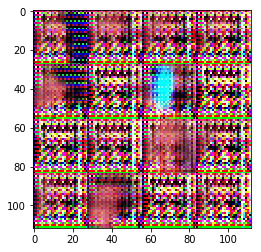

Epoch 1/1... Discriminator Loss: 0.1888... Generator Loss: 3.1358
Epoch 1/1... Discriminator Loss: 4.2427... Generator Loss: 0.0796
Epoch 1/1... Discriminator Loss: 0.3511... Generator Loss: 1.7909
Epoch 1/1... Discriminator Loss: 5.1807... Generator Loss: 6.5690
Epoch 1/1... Discriminator Loss: 0.3261... Generator Loss: 2.3597
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 2.9555
Epoch 1/1... Discriminator Loss: 0.1384... Generator Loss: 2.3968
Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 3.8930
Epoch 1/1... Discriminator Loss: 0.4976... Generator Loss: 3.8357
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 1.5061


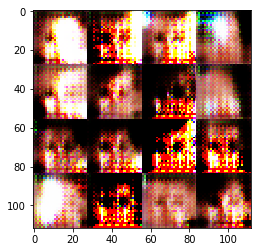

Epoch 1/1... Discriminator Loss: 0.1054... Generator Loss: 3.0713
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 1.8735
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 1.3721
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 2.1125
Epoch 1/1... Discriminator Loss: 0.4717... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.2579


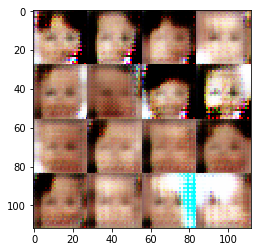

Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.4464
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.9757
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0026
Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 0.8065... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.2927
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 0.7413... Generator Loss: 1.1732


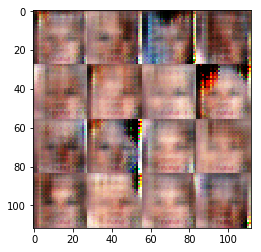

Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.3886
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.8381... Generator Loss: 2.2044
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.5427


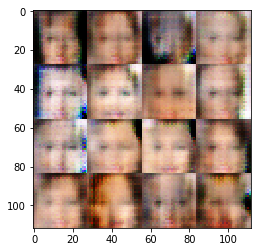

Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.4454
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.2481
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.1578... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 1.1964
Epoch 1/1... Discriminator Loss: 1.6689... Generator Loss: 0.3010
Epoch 1/1... Discriminator Loss: 2.0707... Generator Loss: 0.1879
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.5844


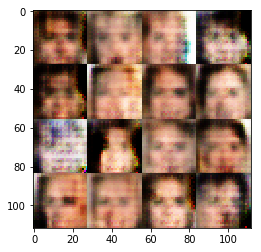

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.4129
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.7635... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.1452... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.4733


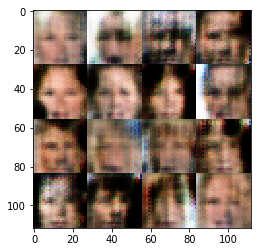

Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 0.7089... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 1.4629
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.9716
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.3129
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 1.2360


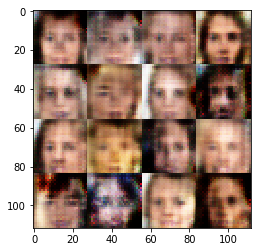

Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.5581
Epoch 1/1... Discriminator Loss: 2.4793... Generator Loss: 2.0023
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.9781
Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.5919
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6794


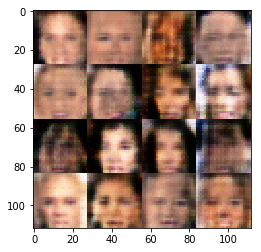

Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.4053
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 1.2160
Epoch 1/1... Discriminator Loss: 0.6096... Generator Loss: 1.6551
Epoch 1/1... Discriminator Loss: 3.7110... Generator Loss: 3.5150


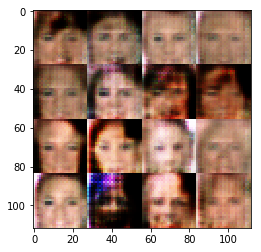

Epoch 1/1... Discriminator Loss: 1.9233... Generator Loss: 0.2378
Epoch 1/1... Discriminator Loss: 1.7840... Generator Loss: 0.3021
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.6340... Generator Loss: 1.7476
Epoch 1/1... Discriminator Loss: 1.8458... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.7384
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.6752


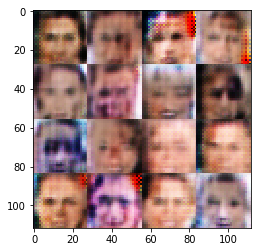

Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 13.0195
Epoch 1/1... Discriminator Loss: 0.1814... Generator Loss: 2.1626
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 1.3786
Epoch 1/1... Discriminator Loss: 2.3739... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 1.8773
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 3.5460
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 1.1038


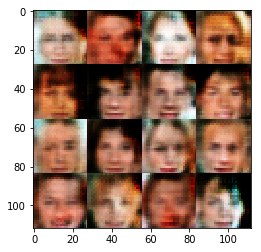

Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 1.1173
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.8747
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.4517
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 7.1663
Epoch 1/1... Discriminator Loss: 1.9084... Generator Loss: 0.2362
Epoch 1/1... Discriminator Loss: 2.8833... Generator Loss: 0.1085
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 2.3133... Generator Loss: 3.4092
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.3756


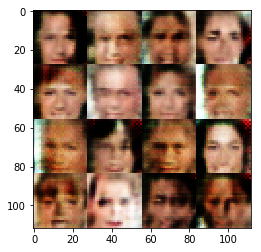

Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.6626


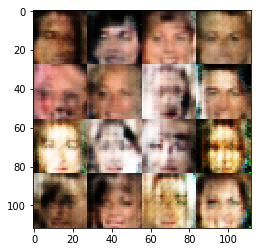

Epoch 1/1... Discriminator Loss: 1.1762... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 1.0053
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.5557
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.9147


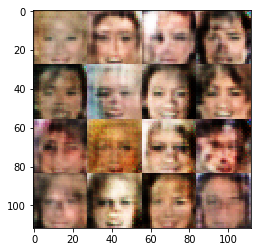

Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.6811


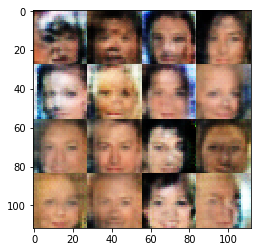

Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.9552


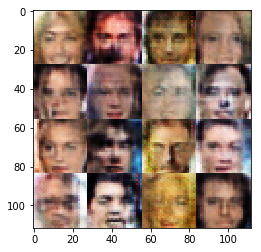

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.2623
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8984


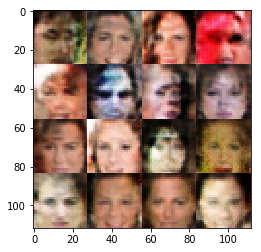

Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.8992


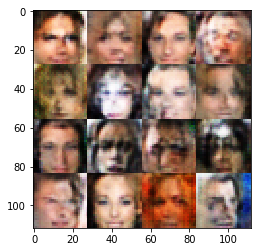

Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.4719


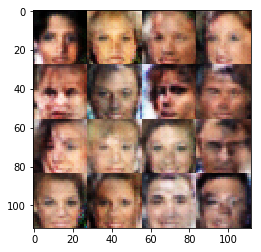

Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.7554... Generator Loss: 0.2886
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.3674
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.9878


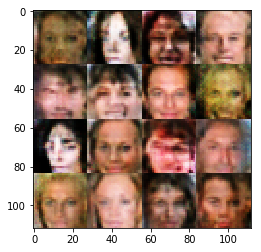

Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.4467


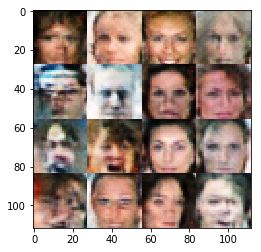

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6174
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.6203


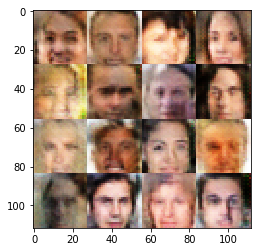

Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.3560
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.6022


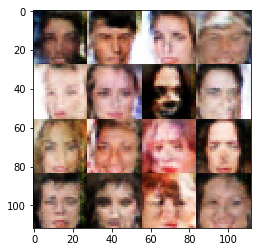

Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.5029


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Training loss

Here we'll check out the training losses for the generator and discriminator.

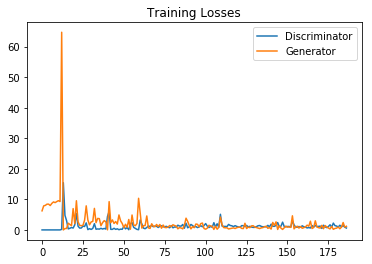

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.